In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Define paths to dataset directories
train_dir = "/content/drive/MyDrive/sem 4 project duk/nutrient demo/training"
val_dir = "/content/drive/MyDrive/sem 4 project duk/nutrient demo/validation"
test_dir ="/content/drive/MyDrive/sem 4 project duk/nutrient demo/testing"

In [8]:
# Define image dimensions
image_size = (224, 224)
num_classes = 4  # Number of categories including "Healthy"

In [9]:
# Define batch size
batch_size = 32

In [6]:
# Create data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Disable shuffling for the test set to evaluate predictions properly
)


Found 2331 images belonging to 4 classes.
Found 134 images belonging to 4 classes.
Found 464 images belonging to 4 classes.


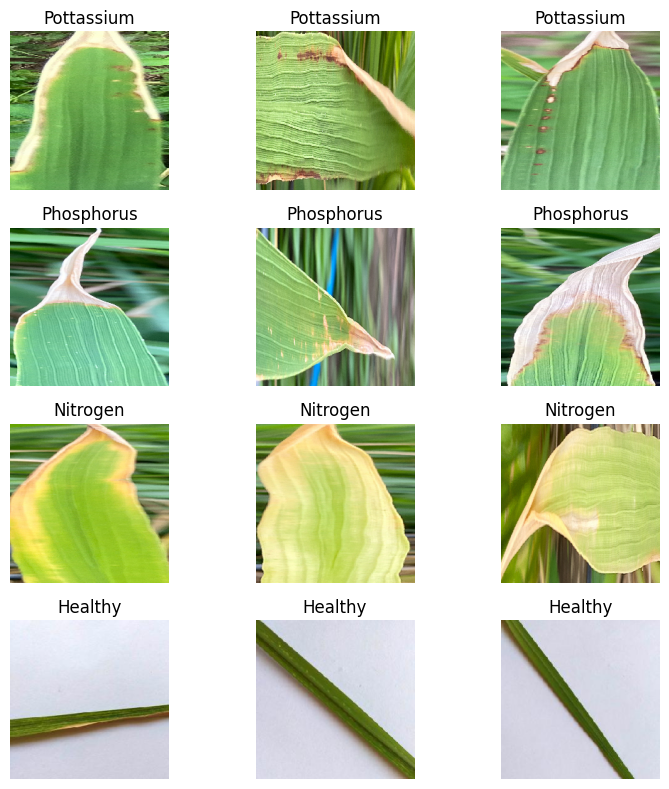

In [14]:


# Function to visualize images from each class in the dataset directory
def visualize_images(dataset_dir, num_images_per_class=3):
    class_names = os.listdir(dataset_dir)
    num_classes = len(class_names)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(8, 8))

    # Loop through each class
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)[:num_images_per_class]

        # Load and display images from the current class
        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_dir, image_file)
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
dataset_dir = "/content/drive/MyDrive/sem 4 project duk/nutrient demo/training"
visualize_images(dataset_dir)


In [10]:
# Load pre-trained GoogLeNet model (InceptionV3) without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


87910968/87910968 [==============================] - 1s 0us/step


In [11]:
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


In [12]:
# Add custom classification layers on top of the pre-trained model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
print("--------------------------------------\n")
model.summary()
print("--------------------------------------\n")

--------------------------------------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24427812 (93.18 MB)
Trainable params: 2625028 (10.01 MB)
Non-trainab

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
print("--------------------------------------\n")
print("Training Started.\n")

--------------------------------------

Training Started.



In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
72/72 [==============================] - 518s 7s/step - loss: 0.3932 - accuracy: 0.8669 - val_loss: 0.3834 - val_accuracy: 0.8438
Epoch 2/10
72/72 [==============================] - 330s 5s/step - loss: 0.1822 - accuracy: 0.9304 - val_loss: 0.3045 - val_accuracy: 0.8516
Epoch 3/10
72/72 [==============================] - 306s 4s/step - loss: 0.1491 - accuracy: 0.9413 - val_loss: 0.2554 - val_accuracy: 0.8828
Epoch 4/10
72/72 [==============================] - 311s 4s/step - loss: 0.1200 - accuracy: 0.9508 - val_loss: 0.4557 - val_accuracy: 0.8516
Epoch 5/10
72/72 [==============================] - 304s 4s/step - loss: 0.1127 - accuracy: 0.9552 - val_loss: 0.2945 - val_accuracy: 0.8984
Epoch 6/10
72/72 [==============================] - 324s 4s/step - loss: 0.0994 - accuracy: 0.9626 - val_loss: 0.2415 - val_accuracy: 0.9062
Epoch 7/10
72/72 [==============================] - 313s 4s/step - loss: 0.0762 - accuracy: 0.9722 - val_loss: 0.3341 - val_accuracy: 0.9219
Epoch 8/10
72

In [ ]:
print("Training Finished.\n")
print("--------------------------------------\n")

Training Finished.

--------------------------------------



In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')


14/14 [==============================] - 61s 4s/step - loss: 0.2048 - accuracy: 0.9196
Test loss: 0.20482900738716125
Test accuracy: 0.9196428656578064


In [ ]:
nutrient_labels = ['Healthy', 'Potassium deficiency', 'Nitrogen deficiency', 'Phosphorus deficiency']

In [ ]:
# Define the nutrient_labels variable

# Define the predict_nutrient_deficiency function with nutrient_labels as an argument
def predict_nutrient_deficiency(image_path, nutrient_labels):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array /= 255.0  # Normalize pixel values

    prediction = model.predict(img_array)
    predicted_class_index = tf.argmax(prediction, axis=1)[0]

    if predicted_class_index == 0:
        return "Healthy"
    else:
        return f"Nutrient deficiency found: {nutrient_labels[predicted_class_index]}"



In [ ]:
# Example usage:
image_path = r"/content/drive/MyDrive/sem 4 project duk/nutrient demo/testing/Healthy/shape 105 .jpg"
predicted_deficiency = predict_nutrient_deficiency(image_path, nutrient_labels)
if predicted_deficiency == "Healthy":
    print("No nutrient deficiency found: Healthy")
else:
    print(predicted_deficiency)


1/1 [==============================] - 0s 130ms/step
No nutrient deficiency found: Healthy


In [ ]:
# Example usage:
image_path = r"/content/drive/MyDrive/sem 4 project duk/nutrient demo/testing/Nitrogen/untitled-93.JPG"
predicted_deficiency = predict_nutrient_deficiency(image_path, nutrient_labels)
if predicted_deficiency == "Healthy":
    print("No nutrient deficiency found: Healthy")
else:
    print(predicted_deficiency)


1/1 [==============================] - 0s 128ms/step
Nutrient deficiency found: Nitrogen deficiency


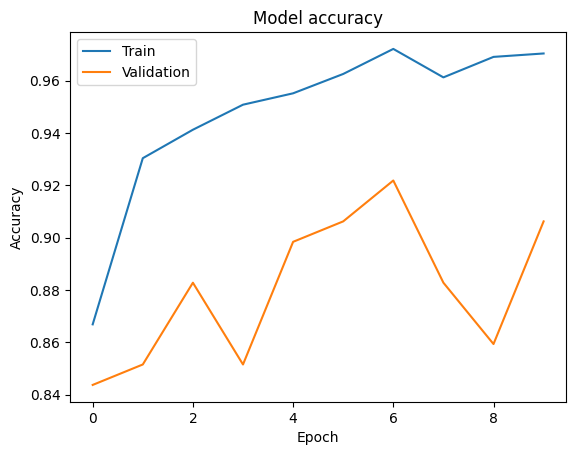

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()

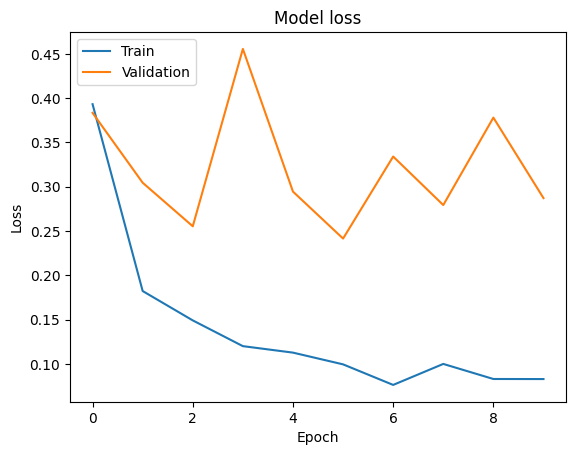

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss_plot.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

15/15 [==============================] - 161s 11s/step
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       234
    Nitrogen       0.97      0.83      0.90        88
 Phosphorous       0.77      0.76      0.76        66
  Pottassium       0.73      0.87      0.80        76

    accuracy                           0.91       464
   macro avg       0.87      0.86      0.86       464
weighted avg       0.92      0.91      0.91       464

